In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
df = pd.read_csv('DATA/cancer_classification.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'DATA/cancer_classification.csv'

In [ ]:
df.info() # checking null values

In [ ]:
df.describe().T

In [ ]:
sns.countplot(x='benign_0__mal_1', data=df)  # checking label counts

In [ ]:
# visually checking correlation of features against label
df.corr()['benign_0__mal_1'][:-1].sort_values().plot(kind='bar')

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())  # correlation heatmap of features

### Training the model

In [ ]:
X = df.drop('benign_0__mal_1', axis=1).values  # removing label from df
y = df['benign_0__mal_1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# scaling the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=1, activation='sigmoid')) # sigmoid since binary

model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(x=X_train, y=y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

In [ ]:
loss = pd.DataFrame(model.history.history)  # checking loss for overfitting
loss.plot()

Past the point at which the graph of loss and validation loss diverge, the model is overfitting, hence epochs too high.

Redefining model, we can use callbacks to prevent overfitting.

In [60]:
X = df.drop('benign_0__mal_1', axis=1).values  # removing label from df
y = df['benign_0__mal_1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# scaling the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=1, activation='sigmoid')) # sigmoid since binary

model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train, y=y_train, epochs=500, verbose=0, validation_data=(X_test, y_test), callbacks=[earlystop])



Epoch 00075: early stopping


This allows us to use any arbitrary value for epochs knowing the callback will prevent overfitting

<AxesSubplot:>

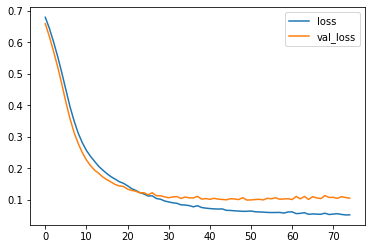

In [61]:
modelloss = pd.DataFrame(model.history.history)
modelloss.plot()

We can further prevent overfitting by using dropout layers, which essentially drop out a percentage of neurons from each layer

In [62]:
#redefining the new model
model = Sequential()
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=15, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid')) # sigmoid since binary

model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train, y=y_train, epochs=500, verbose=0, validation_data=(X_test, y_test), callbacks=[earlystop])


Epoch 00104: early stopping


<AxesSubplot:>

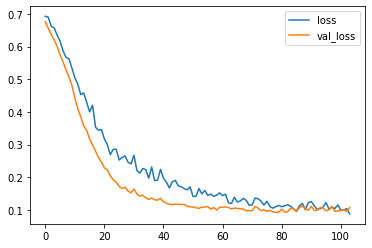

In [63]:
loss = pd.DataFrame(model.history.history)
loss.plot()

This is an improvement to both previous graphs, since both losses are being minimized at the same rate. 

## Making predictions on the test data set using the model

In [64]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        55
           1       0.99      0.95      0.97        88

    accuracy                           0.97       143
   macro avg       0.96      0.97      0.96       143
weighted avg       0.97      0.97      0.97       143

[[54  1]
 [ 4 84]]


/usr/local/lib64/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The model was able to predict malginiancy with 97% accuracy